# Example for cmesh2d and pygmsh

In [1]:
import pygmsh
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from ttcrpy import cmesh2d

Define some function for the slowness

In [2]:
def f(x, y):
    return 1./(1. + 0.4*y + 0.01*x**2)

Create a mesh with pygmsh

In [3]:
geom = pygmsh.built_in.Geometry()

lcar = 0.5

pts = []
pts.append(geom.add_point((0.0, 0.0, 0.0), lcar))
pts.append(geom.add_point((1.0, 0.0, 0.0), lcar))
pts.append(geom.add_point((5.0, 0.0, -2.0), lcar))
pts.append(geom.add_point((10.0, 0.0, 2.0), lcar))
pts.append(geom.add_point((14.0, 0.0, 0.0), lcar))
pts.append(geom.add_point((15.0, 0.0, 0.0), lcar))
pts.append(geom.add_point((15.0, 0.0, 8.0), lcar))
pts.append(geom.add_point((0.0, 0.0, 8.0), lcar))


lines = []
lines.append(geom.add_bspline(pts[:6]))
lines.append(geom.add_line(pts[5], pts[6]))
lines.append(geom.add_line(pts[6], pts[7]))
lines.append(geom.add_line(pts[7], pts[0]))

ll = geom.add_line_loop(lines)

surf = geom.add_plane_surface(ll)

mesh = pygmsh.generate_mesh(geom)

Info    : Running 'gmsh -3 /var/folders/j6/s0152dxj3q54bsjvw2s42b0m0000gn/T/tmpjqt1gqgw.geo -format msh -bin -o /var/folders/j6/s0152dxj3q54bsjvw2s42b0m0000gn/T/tmpzon1r934.msh' [Gmsh 4.5.4, 1 node, max. 1 thread]
Info    : Started on Thu Mar 19 07:47:51 2020
Info    : Reading '/var/folders/j6/s0152dxj3q54bsjvw2s42b0m0000gn/T/tmpjqt1gqgw.geo'...
Info    : Done reading '/var/folders/j6/s0152dxj3q54bsjvw2s42b0m0000gn/T/tmpjqt1gqgw.geo'
Info    : Meshing 1D...
Info    : [  0 %] Meshing curve 1 (Nurb)
Info    : [ 30 %] Meshing curve 2 (Line)
Info    : [ 50 %] Meshing curve 3 (Line)
Info    : [ 80 %] Meshing curve 4 (Line)
Info    : Done meshing 1D (0.006826 s)
Info    : Meshing 2D...
Info    : Meshing surface 6 (Plane, Frontal)
Info    : Done meshing 2D (0.02755 s)
Info    : Meshing 3D...
Info    : Done meshing 3D (2.8e-05 s)
Info    : 625 nodes 1248 elements
Info    : Writing '/var/folders/j6/s0152dxj3q54bsjvw2s42b0m0000gn/T/tmpzon1r934.msh'...
Info    : Done writing '/var/folders/j6/s015

```cmesh2d``` want (x,z) coordinates, extract those from the mesh

In [4]:
nodes = np.vstack((mesh.points[:,0], mesh.points[:,2])).T

triangles = mesh.cells_dict['triangle']

Compute centroid of triangles and compute slowness at these coordonates

In [6]:
x = []
z = []
for t in triangles:
    x.append((nodes[t[0],0] + nodes[t[1],0] + nodes[t[2],0])/3.0)
    z.append((nodes[t[0],1] + nodes[t[1],1] + nodes[t[2],1])/3.0)

slowness = f(np.array(x), np.array(z))
V = 1./slowness   # for plotting

Create mesh and define source & receivers

In [9]:
m1 = cmesh2d.Mesh2D(nodes, triangles, nsecondary=10, nthreads=1)

Tx = np.array([[0.15, 0.15]])
t0 = np.array([0.0])

Rx = np.array([[2.0, -0.4],
               [5.0, -0.7],
               [7.0, -0.1],
               [10.0, 1.0],
               [14.0, 0.2],
               [14.5, 2.0],
               [14.5, 4.0],
               [14.5, 6.0]])

Compute traveltimes & raypaths

In [10]:
tt, _, rays = m1.raytrace(slowness, Tx, Rx, t0, nout=3)

Show raypaths

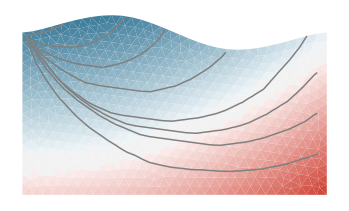

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

patches = []
for t in triangles:
    pts = np.array([[nodes[t[0],0], nodes[t[0],1]],
                    [nodes[t[1],0], nodes[t[1],1]],
                    [nodes[t[2],0], nodes[t[2],1]]])
    p = matplotlib.patches.Polygon(pts, closed=True)
    patches.append(p)
colors = V

cmap = sns.diverging_palette(230, 15, sep=20, as_cmap=True)

p = matplotlib.collections.PatchCollection(patches, cmap=cmap)
p.set_array(np.array(colors))
ax.add_collection(p)


for r in rays:
    plt.plot(r[:,0], r[:,1], c=[0.5, 0.5, 0.5])

ax.invert_yaxis()
plt.axis('off')
plt.show()

Check traveltime values

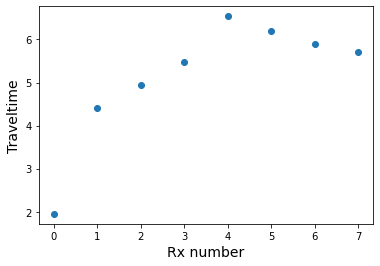

In [13]:
fig = plt.figure()
plt.plot(tt, 'o')
plt.xlabel('Rx number', fontsize=14)
plt.ylabel('Traveltime', fontsize=14)
plt.show()

Check raytracing options

In [14]:
help(m1.raytrace)

Help on built-in function raytrace:

raytrace(...) method of ttcrpy.cmesh2d.Mesh2D instance
    raytrace(slowness, Tx, Rx, t0, nout, thread_no) -> tt,L,rays
    
    Compute traveltimes for a single source.  The source can comprise many
    points, each having its own otigin time (t0).
    
    Parameters
    ----------
    slowness : vector of slowness at cells
    Tx : source coordinates, ndarray of size nTx by 2
        1st column contains X coordinates,
        2nd contains Z coordinates
    Rx : receiver coordinates, ndarray of size nRx by 2
        1st column contains X coordinates,
        2nd contains Z coordinates
    t0 : origin times, scalar or ndarray of size nTx
    nout : number of output variables (1, 2 or 3)
    thread_no : thread/process number on which computation should be run
    
    Returns
    -------
    tt : travel times
    L : (if nout > 1) data kernel matrix (scipy csr) (tt = L*slowness)
    rays : (if nout == 3) coordinates of rays

